In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random


In [ ]:
"""
df = pd.read_csv ('smoke_detection_iot.csv')
df= df.sample(frac=1)         #suffles the data, this is because they were sorted by Fire alarm

df=df.drop(['Unnamed: 0','UTC','CNT'],axis=1)


df.head(37578).to_csv('train.csv')
df.tail(25052).to_csv('test_and_validation.csv')  #first half of test_and_validation is for test, the second half is for valiadation only  
                                                  #60-20-20 train,test,validation split.
df.to_csv('suffeled.csv')

#So that if I accidentally run the program, I won't accidentally train on test or validation data
"""

In [2]:
df = pd.read_csv ('train.csv')
df=df.drop(['Unnamed: 0'], axis=1)
X_d=df.drop(['Fire Alarm'], axis=1) #_d means dataframe version of the matrix
Y_d=df['Fire Alarm']

In [3]:
df 

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,26.940,47.03,1122,598,12821,19458,939.054,2.30,2.39,15.81,2.465,0.056,1
1,-4.158,43.37,132,400,12794,20600,937.413,2.00,2.08,13.75,2.145,0.048,0
2,20.400,46.92,17,400,13214,20139,939.600,0.88,0.92,6.06,0.946,0.021,0
3,20.531,47.86,1182,400,12921,19432,938.688,1.39,1.44,9.56,1.490,0.034,1
4,12.354,48.59,164,436,12771,20557,937.370,1.70,1.76,11.67,1.820,0.041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37573,13.116,45.07,65,449,12794,20705,937.495,2.20,2.29,15.15,2.363,0.053,0
37574,-4.080,55.26,301,400,13111,19963,939.424,0.31,0.33,2.16,0.337,0.008,1
37575,5.410,53.29,1048,669,12795,19483,939.057,2.67,2.77,18.35,2.862,0.065,1
37576,18.770,47.62,1132,609,12805,19450,939.030,2.03,2.11,13.97,2.178,0.049,1


In [6]:
X =X_d.to_numpy() #Normalize X
Y=Y_d.to_numpy()
def normalize(X):
    mean=[]
    std=[]
    for i in range(12):
        mean.append(np.mean(X[:,i]))
        std.append(np.std(X[:,i]))
    mean=np.array(mean)
    std=np.array(std)
    a=np.ones((len(X[:,1])))
    X_std=np.divide(X-np.outer(a,mean),np.outer(a,std))
    return X_std
X_std=normalize(X)

If we use the first 0 Principal Components, the total explained variance is:0.0
If we use the first 1 Principal Components, the total explained variance is:0.5233308417468326
If we use the first 2 Principal Components, the total explained variance is:0.6777496570809236
If we use the first 3 Principal Components, the total explained variance is:0.8004172346663405
If we use the first 4 Principal Components, the total explained variance is:0.873062198763229
If we use the first 5 Principal Components, the total explained variance is:0.9161051464600126
If we use the first 6 Principal Components, the total explained variance is:0.9471111945814092
If we use the first 7 Principal Components, the total explained variance is:0.9705926851577318
If we use the first 8 Principal Components, the total explained variance is:0.989497534917677
If we use the first 9 Principal Components, the total explained variance is:0.9999999999989929
If we use the first 10 Principal Components, the total explained va

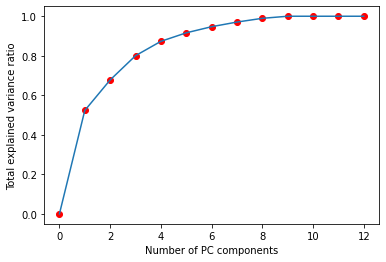

In [10]:
#PCA
cov_X= (np.matmul(X_std.T,X_std))/len(X_std[:,1]) #Same result with np.cov(X_std,rowvar=False)
eigval_X ,eigvec_X =np.linalg.eig(cov_X)
index=eigval_X.argsort()[::-1] #to sort eigenvalues and vectors (max to min)
eigval_X=eigval_X[index]
eigvec_X=eigvec_X[:,index]
total_var_explained=sum(eigval_X)

cum_var_explained=[0]
for i in range(12):
    cum_var_explained.append(sum(eigval_X[:i+1]))
total_var_explained_ratio=cum_var_explained/total_var_explained
plt.plot([x for x in range(13)],total_var_explained_ratio , 'ro')
plt.plot([x for x in range(13)],total_var_explained_ratio )    #I picked 6 PC because the total var explained was 94.71
plt.xlabel('Number of PC components')
plt.ylabel('Total explained variance ratio')
for i in range(13):
    print(f'If we use the first {i} Principal Components, the total explained variance is:{total_var_explained_ratio[i]}')
#plt.savefig('total_var_explained.png') 

In [11]:
X_prjct=np.dot(X_std,eigvec_X[:,:6])#data projected to 6 different eigenvectors where the eigen vectors are #len=12
#the new 6 columns represent the length of the projection to the PC where it goes PC1,PC2...PC6 
#(to go back to the original data, we can use np.matmul(X_prjct,eigvec_X[:,:6].T)) Note that there will be lost infromation.
X_dsgn=np.c_[ np.ones(len(X_prjct[:,1])),X_prjct]  

In [12]:
#Logistic regression 
#useful functions
def sigmoid(x):
    return 1/(1 + math.exp(-x))

def cross_entropy_loss_total(X,Y,b):#Y-> correct classification, X-> Data with length of features + 1(design), b-> beta values
    total=0
    for i in range(len(Y)):
        total+=Y[i]*(math.log(sigmoid(np.dot(b,X[i,:])))) + (1-Y[i])*(math.log(1-sigmoid(np.dot(b,X[i,:]))))
    return (-1/len(X[:,0]))*total

def gradient(X,Y,b,b_j): #b_j is the subscript of beta that the loss is differentiated to. (i.e. 0,1,2,3..)
    total=0
    for i in range(len(Y)):
        total+= (sigmoid(np.dot(b,X[i,:]))-Y[i])*X[i,b_j]
    return (1/len(Y))*total

def gradient_descent(learning_rate,X,Y,b):
    c=b.copy() #This line is because it gradient function uses b, and we don't want it changeing during a single epoch
    for j in range(len(b)):
        b[j]=b[j]-learning_rate*gradient(X,Y,c,j)
    return b
def prediction(X_dsgn,b,threshold):
    y_prediction=[]
    for i in range(len(X_dsgn[:,1])):
        if sigmoid(np.matmul(b,X_dsgn[i,:]))> threshold:
            y_prediction.append(1)
        else:
            y_prediction.append(0)
    return y_prediction
def accuracy(Y,X_dsgn,threshold,b):
    total=0 
    for i in range(len(Y)):
        pred=0
        if sigmoid(np.dot(b,X_dsgn[i,:]))> threshold:
            pred=1
        else:
            pred=0
        total+=abs(pred-Y[i])
    return (1-total/len(Y))

In [13]:
df_t = pd.read_csv ('test_and_validation.csv').tail(12526) #test data, _t indicates test, _v indicates validation
df_t=df_t.drop(['Unnamed: 0'], axis=1)
X_dt=df_t.drop(['Fire Alarm'], axis=1).to_numpy() #_d means dataframe version of the matrix
Y_dt=df_t['Fire Alarm'].to_numpy()
X_std_t=normalize(X_dt) #standardized test data
X_prjct_t=np.dot(X_std_t,eigvec_X[:,:6]) #standardized then projected test data to PC components
X_dsgn_t=np.c_[ np.ones(len(X_prjct_t[:,1])),X_prjct_t]  #test design matrix with the first coulmn equaling to 1

In [14]:
df_v = pd.read_csv ('test_and_validation.csv').head(12526) #validation data , _t indicates test, _v indicates validation
df_v=df_v.drop(['Unnamed: 0'], axis=1)
X_dv=df_v.drop(['Fire Alarm'], axis=1).to_numpy() #_d means dataframe version of the matrix
Y_dv=df_v['Fire Alarm'].to_numpy()
X_std_v=normalize(X_dv)   #standardized validation data
X_prjct_v=np.dot(X_std_v,eigvec_X[:,:6]) #standardized then projected validation data to PC components
X_dsgn_v=np.c_[ np.ones(len(X_prjct_v[:,1])),X_prjct_v]  #validation design matrix with the first column equaling to 1

In [29]:
b=[0,0,0,0,0,0,0]#starting at all beta 0 

In [30]:
%%time
train_loss=[cross_entropy_loss_total(X_dsgn,Y,b)]
epoch=10
learing_rate=2
print(f'The coeficients are :{b} \t The cost is: {cross_entropy_loss_total(X_dsgn,Y,b)} ')
for t in range(epoch):
    b=gradient_descent(learing_rate,X_dsgn,Y,b)
    train_loss.append(cross_entropy_loss_total(X_dsgn,Y,b))
    print(f'The coeficients are :{b} \t The cost is: {cross_entropy_loss_total(X_dsgn,Y,b)} ')

The coeficients are :[0, 0, 0, 0, 0, 0, 0] 	 The cost is: 0.693147180559426 
The coeficients are :[0.43051785619245303, 0.27625400984773646, -0.363236214305598, 0.307263784245058, 0.0699325461602019, 0.05419380215327863, 0.14161464324926265] 	 The cost is: 0.5418216605877906 
The coeficients are :[0.6306495034140629, 0.14845983016037398, -0.42514817240977737, 0.44938415578919433, 0.11254022663782312, 0.08204582471383928, 0.2713073131503164] 	 The cost is: 0.5011718614925802 
The coeficients are :[0.7579197569938683, 0.09083024156491434, -0.4839884573110073, 0.5092120267876796, 0.14127447474535176, 0.10982197336827432, 0.37320911018851366] 	 The cost is: 0.48599919527748514 
The coeficients are :[0.8375670400191727, 0.14302028075814502, -0.5210445883416394, 0.5393068929888591, 0.1624700423794003, 0.13753666544352258, 0.4598648345936015] 	 The cost is: 0.47826720800441747 
The coeficients are :[0.8872947946292341, 0.09905710535252715, -0.5446583398477516, 0.563958797329875, 0.17674314181

In [31]:
print(f'The accuarcy for the traing data is: {accuracy(Y,X_dsgn,0.5,b)}, and the accuarcy for the validation data is: {accuracy(Y_dv,X_dsgn_v,0.5,b)}')
#0.5 is the threshold

The accuarcy for the traing data is: 0.8266006706051413, and the accuarcy for the validation data is: 0.8267603384959284


In [32]:
#Thus, we can see that there is no overfit so we can use the described model above. Final metrics are:
print(f'The accuarcy for the traing data is: {accuracy(Y,X_dsgn,0.5,b)}, and the accuarcy for the test data is: {accuracy(Y_dt,X_dsgn_t,0.5,b)}')

The accuarcy for the traing data is: 0.8266006706051413, and the accuarcy for the test data is: 0.8281175155676194


Text(0.5, 1.0, 'CE Loss vs Epoch, At learning rate = 2')

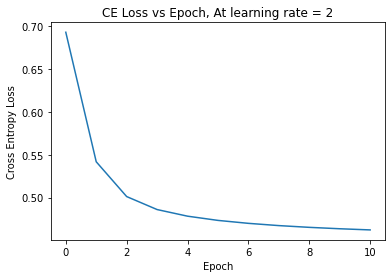

In [33]:
plt.plot([x for x in range(len(train_loss))],train_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Epoch, At learning rate = 2')
#plt.savefig('lr0.1.png')

In [34]:
b_original=[0,0,0,0,0,0,0,0,0,0,0,0,0]

In [35]:
%%time 
# Logistic Regression without PCA
X_dsgn_original=np.c_[ np.ones(len(X_std[:,1])),X_std] #Used standardized version because without it we can see extremely big numbers which makes the math libary give out erros.
print(f'The coeficients are :{b_original} \t The cost is: {cross_entropy_loss_total(X_dsgn_original,Y,b_original)} ')
for t in range(epoch):
    b_original=gradient_descent(2,X_dsgn_original,Y,b_original)
    print(f'The coeficients are :{b_original} \t The cost is: {cross_entropy_loss_total(X_dsgn_original,Y,b_original)} ')

The coeficients are :[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 The cost is: 0.693147180559426 
The coeficients are :[0.43051785619245303, -0.14504150521896836, 0.3592659937347747, -0.19015900445884834, -0.08751673525609366, 0.09677553328392853, -0.31345931984153025, 0.22359629775964257, -0.09918413904770566, -0.07587956642844555, -0.11411275909311014, -0.07393293620925015, -0.05021580898451912] 	 The cost is: 0.5158909240770833 
The coeficients are :[0.6332522727937726, -0.16550168333509724, 0.43151206759878913, -0.22500257414516667, -0.035871350593567164, 0.0754793240423646, -0.5993758728887342, 0.17868359560222838, -0.07118156824943374, -0.04186135723722539, -0.09600702372549187, -0.03960676981767325, -0.013595021698683298] 	 The cost is: 0.4559443403543754 
The coeficients are :[0.7675014809315011, -0.18358363028969807, 0.4830199586208752, -0.29202727890736246, -0.0034945926340634523, 0.0964997412293585, -0.799166396240124, 0.11658547174258353, -0.0571987013218546, -0.01719879003467

In [36]:
 print(f'The accuarcy for the traing data is: {accuracy(Y,X_dsgn_original,0.5,b_original)}, and the accuarcy for the validation data is: {accuracy(Y_dv,np.c_[ np.ones(len(X_std_v[:,1])),X_std_v],0.5,b_original)} test accuaracy is : {accuracy(Y_dt,np.c_[ np.ones(len(X_std_t[:,1])),X_std_t],0.5,b_original)}')

The accuarcy for the traing data is: 0.8715471818617276, and the accuarcy for the validation data is: 0.8688328277183458 test accuaracy is : 0.8687529937729522


In [37]:
#Neural Network
def RelU(x):
    return np.maximum(0, x)

def derRelU(z):
    return (z>0)

def initialize(neurons): #where neurons is a list where all of neuron count info is stored, layer by layer
    B1=[np.random.randn(i) for i in neurons[1:]][0]
    B2=[np.random.randn(i) for i in neurons[1:]][1]
    B3=[np.random.randn(i) for i in neurons[1:]][2] 
    W1=[np.random.randn(j, i) for i,j  in zip(neurons[:-1], neurons[1:])][0] 
    W2=[np.random.randn(j, i) for i,j  in zip(neurons[:-1], neurons[1:])][1] 
    W3=[np.random.randn(j,i) for i,j  in zip(neurons[:-1], neurons[1:])][2] 
    return [W1,W2,W3], [B1,B2,B3]

def feed_forward(x,W,B): #inputs a single example, outputs Activations ,  z and the output of the network
    z1=(np.matmul(W[0],np.array(x).T)+B[0])
    a1=RelU(z1)
    z2=(np.matmul(W[1], a1)+B[1])
    a2=RelU(z2)
    z3=(np.matmul(W[2], a2)+B[2])
    a3=sigmoid(z3)
    output=a3
    return [x,a1,a2],[z1,z2,z3], output

def back_prop(y,W,B,A,Z,output): #for a sinlge example
    #output delta
    delta_out=[np.array([output-y])]
    #hidden delta
    for w, b, a in zip( W[::-1],B[::-1],A[::-1]):
        delta_out.append(np.multiply(np.matmul(w.T,delta_out[-1]), derRelU(a))) 
    delta_out=delta_out[::-1][1:]   #remove dC/dinput
    d_weights=[]
    for i ,a in zip(delta_out,A):
        d_weights.append(np.matmul(np.reshape(i,(len(i),1)), np.reshape(a,(1,len(a)) ))) 
    d_bias=delta_out
    return d_weights, d_bias

def update_network(dw,db,W,B,lr):
    for i in range(len(W)):
        W[i]=np.subtract(W[i],dw[i]*lr)
        B[i]=np.subtract(B[i],db[i]*lr)
    return W,B

def cross_entropy_neural(o,y): #single
    return  -(y*math.log(o)+ (1-y)*math.log(1.0001- o)) #causes domain error if it was 1

def loss_and_accuracy(X_t,Y_t,X_v,Y_v,W,B):
    total_loss_t=0
    total_loss_v=0
    accuracy_t=0
    accuracy_v=0
    for xx_t,yy_t in zip(X_t,Y_t):
            total_loss_t+= cross_entropy_neural(feed_forward(np.array(xx_t),W,B)[-1],yy_t)
            accuracy_t+= abs(yy_t- (feed_forward(np.array(xx_t),W,B)[-1]>0.5))
    for xx_v,yy_v in zip(X_v,Y_v):
        total_loss_v+= cross_entropy_neural(feed_forward(np.array(xx_v),W,B)[-1],yy_v)
        accuracy_v+= abs(yy_v- (feed_forward(np.array(xx_v),W,B)[-1]>0.5))
    #return f'train loss ={total_loss_t/len(Y_t)} val: {total_loss_v/len(Y_v)} accuracy: {1-accuracy_t/len(Y_t)} val:{1-accuracy_v/len(Y_v)}'
    return total_loss_t/len(Y_t), total_loss_v/len(Y_v), 1-accuracy_t/len(Y_t), 1-accuracy_v/len(Y_v)
def SGD(X_t,Y_t,X_v,Y_v,W,B,epoch,lr):
    loss_t=[]
    loss_v=[]
    for x_t,y_t in zip(X_t[:epoch],Y_t[:epoch]):
        total_loss_t=0
        total_loss_v=0
        accuracy_t=0
        accuracy_v=0
        A,Z,output= feed_forward(np.array(x_t),W,B)
        
        """for xx_t,yy_t in zip(X_t,Y_t):
            total_loss_t+= cross_entropy_neural(feed_forward(np.array(xx_t),W,B)[-1],yy_t)
            accuracy_t+= abs(yy_t- (feed_forward(np.array(xx_t),W,B)[-1]>0.5))
        for xx_v,yy_v in zip(X_v,Y_v):
            total_loss_v+= cross_entropy_neural(feed_forward(np.array(xx_v),W,B)[-1],yy_v)
            accuracy_v+= abs(yy_v- (feed_forward(np.array(xx_v),W,B)[-1]>0.5))
        print(f'train loss ={total_loss_t/len(Y_t)} val: {total_loss_v/len(Y_v)} accuracy: {1-accuracy_t/len(Y_t)} val:{1-accuracy_v/len(Y_v)} ')
        loss_t.append(total_loss_t/len(Y_t))
        loss_v.append(total_loss_v/len(Y_v))"""
        
        dw,db = back_prop(y_t,W,B,A,Z,output)
        W,B=update_network(dw,db,W,B,lr)
    return W,B,loss_t, loss_v

def MBSGD(X_t,Y_t,X_v,Y_v,W,B,epoch,lr,batchsize):
    loss_t=[]
    loss_v=[]
    for i in range(epoch):
        c=list(zip(X_t,Y_t))
        random.shuffle(c)
        c=c[:batchsize]
        x_one,y_one = zip(*c)
        total_w=0
        total_b=0
        count=0
        for x_t,y_t in zip(x_one,y_one): #one batch
            A,Z,output= feed_forward(np.array(x_t),W,B)
            dw,db = back_prop(y_t,W,B,A,Z,output)
            if count==0:
                total_w=dw
                total_b=db
                count+=1
            else:
                for i in range(len(dw)): #inside W
                    total_w[i]=np.add(total_w[i],dw[i])
                    total_b[i]=np.add(total_b[i],db[i])
        M=loss_and_accuracy(X_t,Y_t,X_v,Y_v,W,B)
        loss_t.append(M[0])
        loss_v.append(M[1])
        print(f'train loss= {M[0]} val loss: {M[1]} train accuracy{M[2]} val accuracy:{M[3]}')
        W,B=update_network(total_w,total_b,W,B,lr/batchsize)
    return W,B,loss_t, loss_v

In [47]:
W,B=initialize([6,18,18,1])
loss_and_accuracy(X_prjct,Y,X_prjct_v,Y_dv,W,B) #outputs trainloss,valloss, train accuracy, val accuracy

(12.498595389493577,
 12.539541715525354,
 0.2732449837670977,
 0.27247325562829317)

In [48]:
%%time
W_new,B_new,loss_t,loss_v = MBSGD(X_prjct,Y,X_prjct_v,Y_dv,W,B,100,0.1,100)

train loss= 12.498595389493577 val loss: 12.539541715525354 train accuracy0.2732449837670977 val accuracy:0.27247325562829317
train loss= 2.453666324362388 val loss: 2.4499573037107463 train accuracy0.729203257224972 val accuracy:0.7302410985150887
train loss= 2.1005614243768815 val loss: 2.13068527024235 train accuracy0.5535153547288307 val accuracy:0.547102027782213
train loss= 1.6510994993702985 val loss: 1.6785875902590135 train accuracy0.6930384799616798 val accuracy:0.6922401405077439
train loss= 1.7389674198971363 val loss: 1.7613119626341571 train accuracy0.5039384746394167 val accuracy:0.5016765128532652
train loss= 1.5566149466721404 val loss: 1.5957783512956243 train accuracy0.7827984458991963 val accuracy:0.7787003033689925
train loss= 3.2782077444791655 val loss: 3.3026389843976895 train accuracy0.3253765501091064 val accuracy:0.3177391026664538
train loss= 2.1940189461011843 val loss: 2.2179687158341195 train accuracy0.7285113630315609 val accuracy:0.7308797700782372
trai

A,Z,output= feed_forward(np.array([1,0.4,-1,-1,1,2]),W,B)
dw, db= back_prop(0,W,B,A,Z,output)
W,B=update_network(dw,db,W,B,0.01)

W,B=update_network(dw,db,W,B,0.01)

In [49]:
loss_and_accuracy(X_prjct,Y,X_prjct_v,Y_dv,W,B)

(0.25041571904307497,
 0.2574272711697536,
 0.8826441002714354,
 0.8805684176912023)

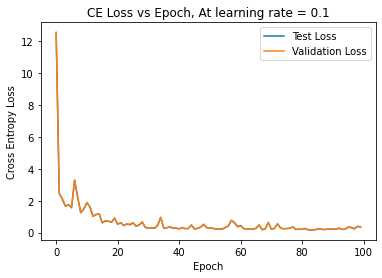

In [50]:
plt.plot([i for i in range(len(loss_t))],loss_t,label="Test Loss")
plt.plot([i for i in range(len(loss_v))],loss_v,label="Validation Loss")
plt.legend(['Test Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Epoch, At learning rate = 0.1')
plt.savefig('MBSGD0.1.png')

In [51]:
%%time
W_new,B_new,loss_t,loss_v=SGD(X_prjct,Y,X_prjct_v,Y_dv,W,B,15000,0.001)
loss_and_accuracy(X_prjct,Y,X_prjct_v,Y_dv,W,B)

CPU times: user 2.3 s, sys: 17.4 ms, total: 2.32 s
Wall time: 2.31 s


(0.14331000041974554,
 0.1498050993906608,
 0.9487199957421896,
 0.9359731757943478)